# Import all necessary libraries

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Loading a dataset and splitting it into training and testing sets to avoid data leakage

In [56]:
# Load data
path = "data/properties.csv"
df = pd.read_csv(path)


# Split data into training and test sets to avoid data leakage
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df.columns.tolist()

['id',
 'price',
 'property_type',
 'subproperty_type',
 'region',
 'province',
 'locality',
 'zip_code',
 'latitude',
 'longitude',
 'construction_year',
 'total_area_sqm',
 'surface_land_sqm',
 'nbr_frontages',
 'nbr_bedrooms',
 'equipped_kitchen',
 'fl_furnished',
 'fl_open_fire',
 'fl_terrace',
 'terrace_sqm',
 'fl_garden',
 'garden_sqm',
 'fl_swimming_pool',
 'fl_floodzone',
 'state_building',
 'primary_energy_consumption_sqm',
 'epc',
 'heating_type',
 'fl_double_glazing',
 'cadastral_income']

# Defining a target and features by type

In [28]:
# define target value
target = 'price'

# Categorical and numerical feature names
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = [col for col in df_train.columns if col not in categorical_features + [target]]


# Creating a pipeline to preprocess the data

In [29]:
# Numerical data preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical data preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Creating a model

In [54]:
# Create a pipeline that first preprocesses the data, then trains a model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features=None,
        max_depth=20,
        random_state=42  # Ensuring reproducibility
    ))
])


# Fitting the model

In [31]:
X_train = df_train.drop([target], axis=1)
y_train = df_train[target]

model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'zip_code', 'latitude',
                                                   'longitude',
                                                   'construction_year',
                                                   'total_area_sqm',
                                                   'surface_land_sqm',
                                                   'nbr_frontages',
                                                   'nbr_bedrooms',
                                                   'fl_furnished',
                                                   'fl_open_fire', 'fl_terrace',
                                                   'terrace_sqm', 'fl_...
                                                   'fl_double_glazing',
                                                   'cadastral_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type',
                                                   'subproperty_type', 'region',
                                                   'province', 'locality',
                                                   'equipped_kitchen',
                                                   'state_building', 'epc',
                                                   'heating_type'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Evaluating the model

In [32]:
X_test = df_test.drop([target], axis=1)
y_test = df_test[target]

y_pred = model_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Score: {round(model_pipeline.score(X_test, y_test) * 100, 2)}%")


Mean Squared Error: 36159281417.74366
Root Mean Squared Error: 190155.9397382676
Score: 79.22%


# Finding the best hyperparameters

In [33]:
param_distributions = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(model_pipeline, param_distributions=param_distributions, n_iter=10, cv=5, random_state=42)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print(f"Best parameters found: {search.best_params_}")


Best parameters found: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': None, 'regressor__max_depth': 20}


# Evaluating the best model

In [51]:
y_pred_tuned = best_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)

print(f"Mean Squared Error (Tuned): {mse_tuned}")
print(f"Root Mean Squared Error (Tuned): {rmse_tuned}")
print(f'Score (Tuned): {round(best_model.score(X_test, y_test) * 100, 2)}%')


Mean Squared Error (Tuned): 37505778039.17024
Root Mean Squared Error (Tuned): 193664.0855687245
Score (Tuned): 78.44%


# Cross-Validation

It splits the dataset into multiple smaller train-test sets and evaluating the model on each. This approach helps ensure the model performs well across different data samples.

In [35]:
from sklearn.model_selection import cross_val_score

# Assuming `best_model` is your final model after hyperparameter tuning
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive MSE scores
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)

print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE:", rmse_scores.std())


Cross-validated RMSE scores: [252364.63022817 214946.62654464 227861.67315678 246858.16608462
 275980.37594275]
Mean RMSE: 243602.2943913904
Standard deviation of RMSE: 20998.25636256498


# Learning Curves

Learning curves plot the model's performance on the training set and the validation set as a function of the number of training samples. Plots can help to understand if adding more data improves model performance or if the model suffers from high bias or high variance.

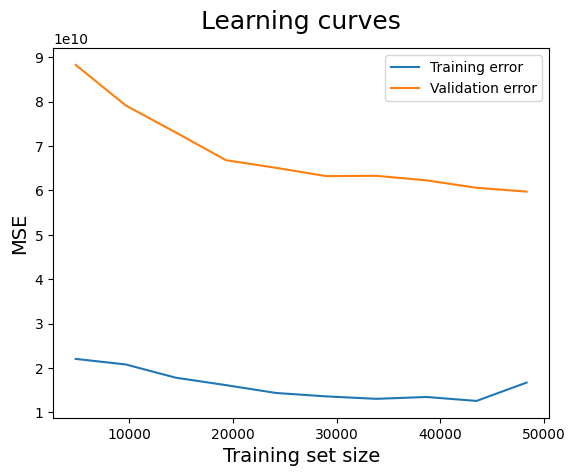

In [48]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_model,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()


# Feature Importance Analysis

In [45]:
# Get the feature names after OneHotEncoding and other transformations
# Adjust 'preprocessor' and 'regressor' based on your pipeline steps' names
feature_names_transformed = best_model.named_steps['preprocessor'].transformers_

# Initialize an empty list to hold the feature names
transformed_feature_names = []

# Iterate through each transformer and collect the feature names
for transformer_name, transformer, original_features in feature_names_transformed:
    if transformer_name != 'remainder':
        if hasattr(transformer, 'get_feature_names_out'):
            # For transformers with 'get_feature_names_out' method, use it
            transformed_features = transformer.get_feature_names_out(original_features)
            transformed_feature_names.extend(transformed_features)
        else:
            # For transformers without 'get_feature_names_out', use the original feature names
            transformed_feature_names.extend(original_features)
    else:
        # If 'remainder', add the original feature names that were not transformed
        transformed_feature_names.extend(original_features)

# Now, 'transformed_feature_names' contains the correctly transformed feature names


In [57]:
import plotly.graph_objects as go

# Prepare the data for Plotly
importances_sorted = importances[indices]
names_sorted = [transformed_feature_names[i] for i in indices]

# Create a Plotly figure
fig = go.Figure()

# Add a bar chart to the figure
fig.add_trace(go.Bar(x=names_sorted, y=importances_sorted))

# Customize the layout
fig.update_layout(
    title="Feature Importance",
    xaxis_title="Feature",
    yaxis_title="Importance",
    xaxis={'categoryorder':'total descending'},  # This orders the bars based on their y-value (importance)
    xaxis_tickangle=-45  # Rotate labels for better readability
)

# Show the figure
fig.show()
